<h1> A Basic Data Science Project: Titanic Dataset <h1>

In [32]:
#import the necessary libraries for data manipulation and visualization
import numpy as np 
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression 
from sklearn.cross_validation import train_test_split 
from sklearn import metrics
from sklearn.metrics import classification_report

In [33]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

First we read the data in using the Pandas read_csv function. I downloaded the dataset off of Kaggle in the form of a csv file. We want to read our data into a Pandas DataFrame. We are going to be predicting whether passengers survived or not. This is a binary output.

In [34]:
#specify the file path to the training data, already downloaded and saved in the same directory
train_data = pd.read_csv("train.csv")
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [35]:
#now we explore the data a bit
print("shape: {}".format(train_data.shape)) #show number of rows and columns

#show the number of missing values for each category
print(train_data.apply(lambda x: sum(x.isnull()), axis=0))

shape: (891, 12)
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


One of the first steps when cleaning up data is to get rid of the data that is unnecessary. In this case, we can get rid of PassengerId since it was a made up value by Kaggle, Ticket since it is unlikely to have any correlation on survival rate, and Cabin because it has so few values.

In [37]:
train_data = train_data.drop(['PassengerId','Ticket', 'Cabin'], 1)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [38]:
#explore the data by grouping it and seeing the value counts for Survival rate
train_data.groupby('Sex').Survived.value_counts() 

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

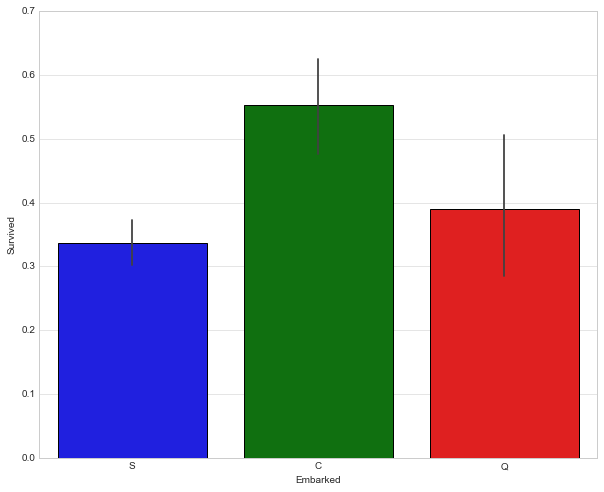

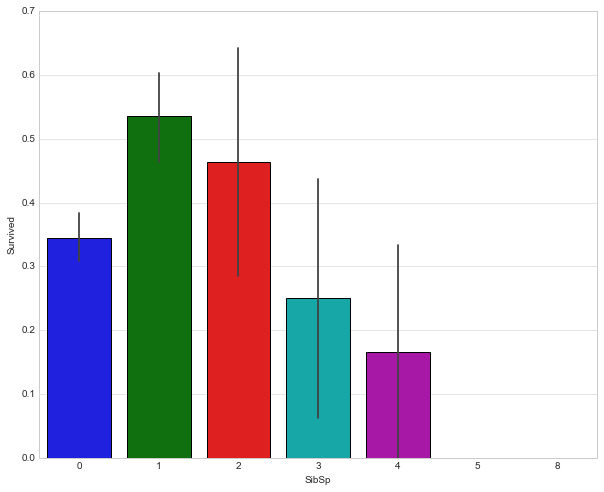

<function matplotlib.pyplot.show>

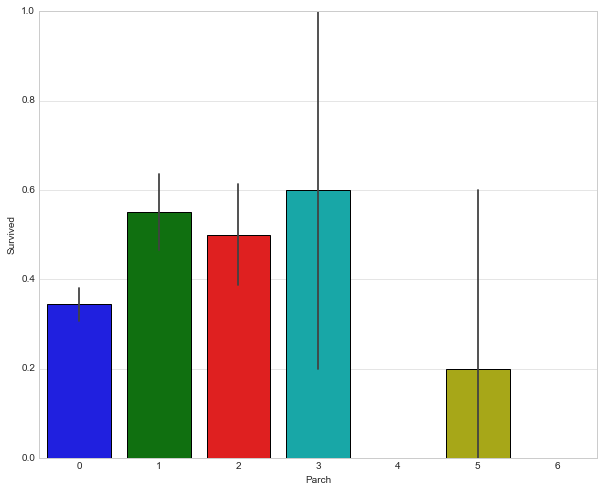

In [39]:
#explore the data by graphing to visualize possible trends and correlations

sb.barplot(x="Embarked", y="Survived", data=train_data)
plt.show()

sb.barplot(x="SibSp", y="Survived", data=train_data)
plt.show()

sb.barplot(x="Parch", y="Survived", data=train_data)
plt.show

We will need everything to be in a format that is digestible for our modeling.
This means mapping Name, Sex, and Embarked to numeric values.
Since we are missing values from Age, we need to find a way to fill those in. We can check to see if there are any other columns that correlate with Age. After checking all the columns, the one that correlates best is Pclass. We use a violinplot in Seaborn so that we can see the variance and the mode. So, we can use the average ages for each class bucket (1, 2, 3) and fill in those ages for the missing values.   

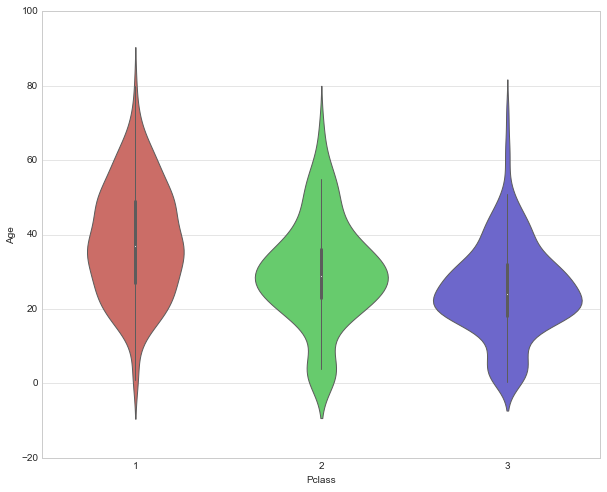

In [40]:
sb.violinplot(x='Pclass', y='Age', data=train_data, palette='hls')

In [41]:
#This is the function to fill in the missing age values by using the approximations based off of Pclass
def age_approx(cols): 
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age): 
        if Pclass == 1:
            return 38 
        elif Pclass == 2: 
            return 30
        else:
            return 23
    else:
        return Age

In [42]:
train_data['Age'] = train_data[['Age', 'Pclass']].apply(age_approx, axis=1)
train_data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Now we look at the Embarked data since that was missing a couple of values. It is clear that the large majority of passengers embarked at S. So we can fill in S for our couple missing values.

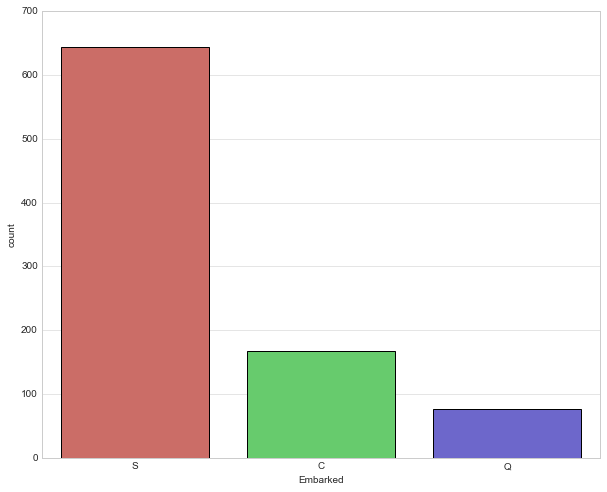

In [43]:
sb.countplot(x='Embarked',data=train_data, palette='hls')

In [44]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')

One column of data that is particularly interesting is Name. While the actual name of a person obviously would not be a predictor of their survival, their title, which is contained in the Name data, might be. So we will go ahead and extract the Title from Name.

In [45]:
#now we get the title out of the Name column since only the title is relavent for our modeling
train_data["Title"] = train_data["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
print(train_data["Title"].value_counts(normalize=True, ascending=True))

Sir             0.001122
the Countess    0.001122
Capt            0.001122
Mme             0.001122
Ms              0.001122
Don             0.001122
Jonkheer        0.001122
Lady            0.001122
Major           0.002245
Col             0.002245
Mlle            0.002245
Rev             0.006734
Dr              0.007856
Master          0.044893
Mrs             0.140292
Miss            0.204265
Mr              0.580247
Name: Title, dtype: float64


There are too many titles right now, so we are going to combine them into similar categories. By creating these buckets we will be able to keep this as a predictor since generally it is good to have 50 records per predictor and each title category is its own predictor.

In [46]:
#drop the Name column and condense the Title values into smaller groups
train_data = train_data.drop(["Name"], axis=1)
train_data["Title"] = train_data["Title"].replace(["Mlle", "Ms"], "Miss")
train_data["Title"] = train_data["Title"].replace("Mme", "Mrs")
train_data["Title"] = train_data["Title"].replace(["Major", "Capt", "Col"], "Military")
train_data["Title"] = train_data["Title"].replace(["Sir", "the Countess", "Don", "Jonkheer", "Lady", "Rev", "Dr"], "Unusual") #group the rest of unusual and rare names together

In [47]:
print(train_data["Title"].value_counts(normalize=True, ascending=True))

Military    0.005612
Unusual     0.020202
Master      0.044893
Mrs         0.141414
Miss        0.207632
Mr          0.580247
Name: Title, dtype: float64


Now we are going to reformat our categorical values into numerical values. We need to do this so that we can have a binary output of 0 or 1 to represent whether or not a passenger survived. We can use the Pandas get_dummies function for this.

In [48]:
gender = pd.get_dummies(train_data['Sex'],drop_first=True) 
gender.head()

,male
0,1.0
1,0.0
2,0.0
3,0.0
4,1.0


In [49]:
embark_location = pd.get_dummies(train_data['Embarked'],drop_first=True) 
embark_location.head()

,Q,S
0,0.0,1.0
1,0.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [50]:
title = pd.get_dummies(train_data['Title'],drop_first=True) 
title.head()

,Military,Miss,Mr,Mrs,Unusual
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0


In [51]:
train_data.drop(['Sex', 'Embarked', 'Title'],axis=1,inplace=True) 
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [52]:
train_dmy = pd.concat([train_data,gender,embark_location, title],axis=1)
train_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Military,Miss,Mr,Mrs,Unusual
0,0,3,22.0,1,0,7.2500,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Now we can check to see if any of our predictors are correlated with one another. In the heatmap it is clear that Fare and Pclass are highly correlated, as are SibSp and Parch. So we can combine SibSp and Parch into one category called Family. Then we can create buckets for the size of the family. In addition, we will drop Fare and keep only Pclass.

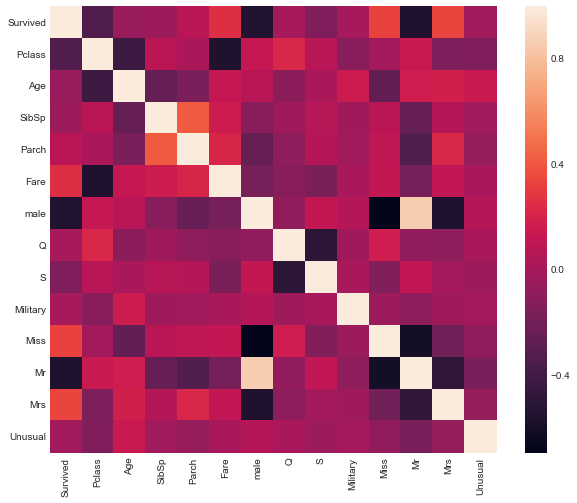

In [53]:
sb.heatmap(train_dmy.corr())

In [54]:
train_dmy.drop(['Fare'],axis=1,inplace=True) 
train_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S,Military,Miss,Mr,Mrs,Unusual
0,0,3,22.0,1,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,1,38.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,26.0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,1,35.0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,3,35.0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [64]:
train_dmy['FamilySize'] = train_dmy['SibSp'] + train_dmy['Parch'] + 1

In [77]:
train_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S,Military,Miss,Mr,Mrs,Unusual,FamilySize
0,0,3,22.0,1,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2
1,1,1,38.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
2,1,3,26.0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
3,1,1,35.0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2
4,0,3,35.0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1


Now we are going to split the data into training and testing data. Then we are going to use Logistic Regression as our first model to see how accurate that is.

In [71]:
X = train_dmy.ix[:,(1,2,3,4,5,6)].values
y = train_dmy.ix[:,0].values

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=3)

In [73]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
y_pred = LogReg.predict(X_test)

Now we can use a confusion matrix to see how many false positives, true positives, etc.

In [75]:
from sklearn.metrics import confusion_matrix 
confusion_matrix = confusion_matrix(y_test, y_pred) 
confusion_matrix

array([[137,  27],
       [ 29,  75]])

In [76]:
#print out the precision and recall, measures of how well the model did
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.84      0.83       164
          1       0.74      0.72      0.73       104

avg / total       0.79      0.79      0.79       268



The Logistic Regression model did alright, but even without trying to modify our feature selection to improve the model, we can just try other models that might be better. 

In [81]:
#use Kfold validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

In [82]:
random_state = 33
models = []
models.append(("RFC", RandomForestClassifier(random_state=random_state)) )
models.append(("ETC", ExtraTreesClassifier(random_state=random_state)) )
models.append(("ADA", AdaBoostClassifier(random_state=random_state)) )
models.append(("GBC", GradientBoostingClassifier(random_state=random_state)) )
models.append(("SVC", SVC(random_state=random_state)) )
models.append(("LoR", LogisticRegression(random_state=random_state)) )
models.append(("LDA", LinearDiscriminantAnalysis()) )
models.append(("QDA", QuadraticDiscriminantAnalysis()) )
models.append(("DTC", DecisionTreeClassifier(random_state=random_state)) )

In [84]:
from sklearn import model_selection
 
kfold = model_selection.KFold(n_splits=10)
 
for name, model in models:
     #cross validation among models, score based on accuracy
     cv_results = model_selection.cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold )
     print("\n[%s] Mean: %.8f Std. Dev.: %8f" %(name, cv_results.mean(), cv_results.std()))


[RFC] Mean: 0.81233999 Std. Dev.: 0.027758

[ETC] Mean: 0.79948797 Std. Dev.: 0.028891

[ADA] Mean: 0.81395289 Std. Dev.: 0.061371

[GBC] Mean: 0.83471582 Std. Dev.: 0.027581

[SVC] Mean: 0.82821301 Std. Dev.: 0.017939

[LoR] Mean: 0.79621096 Std. Dev.: 0.037668

[LDA] Mean: 0.80424987 Std. Dev.: 0.033048

[QDA] Mean: 0.81395289 Std. Dev.: 0.041270

[DTC] Mean: 0.79152586 Std. Dev.: 0.047779


Looks like the best model was GradientBoostingClassifier.